# Denoising del Dataset JUMP Cell con Noise2Void

Questo Notebook descrive in modo strutturato le fasi di **addestramento** e **testing** di una rete neurale di tipo **U-Net** applicata alla **riduzione del rumore** su immagini provenienti dal [Dataset JUMP](https://github.com/jump-cellpainting/datasets).

Il modello utilizza l’algoritmo **Noise2Void (N2V)**, implementato nella libreria [CAREamics](https://careamics.github.io/0.1/).  
Noise2Void consente di ottenere immagini denoised senza la necessità di disporre di **Ground Truth**, caratteristica particolarmente utile nel contesto di immagini microscopiche mediche.

Gli obiettivi principali dell’attività sono:

- Analizzare le potenzialità delle **Deep Neural Networks** nel denoising di immagini biologiche.
- Comprendere il funzionamento e i dettagli dell’algoritmo N2V in un contesto reale.

## Il Dataset JUMP

Il **Dataset JUMP** è costituito da immagini microscopiche di cellule, per le quali **non è disponibile una Ground Truth** a causa delle limitazioni degli strumenti attuali.  
In questo scenario, Noise2Void rappresenta uno strumento particolarmente adatto, grazie alla sua capacità di apprendere direttamente dal rumore presente nelle immagini.

## Download del Dataset

Il dataset JUMP viene scaricato in formato **.TIFF Hyperstack** dalla piattaforma [Zenodo](https://zenodo.org).  
Esso contiene **517 immagini**, ciascuna rappresentata su **4 canali**, per un totale di **2068 immagini** di dimensioni **540x540 pixel**.

I 4 canali separano le componenti **RGB** e **Alpha**, permettendo di distinguere in modo più preciso le diverse strutture cellulari e le relative colorazioni.

### Suddivisione in Training e Validation

Dopo il download, il dataset viene suddiviso in:

- **Training Data**: utilizzato dalla rete neurale per apprendere i pesi ottimali.
- **Validation Data**: utilizzato per monitorare l’andamento dell’addestramento e prevenire possibili fenomeni di **overfitting**.

Per questa attività, si utilizza uno **`split_ratio = 0.8`**, indicando che l’**80% delle immagini** sarà destinato al training e il restante **20%** al validation.


In [1]:
import tifffile
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.utils.metrics import scale_invariant_psnr

sys.path.append('library')

import library.dataset as dataset

In [2]:
# Download del Dataset JUMP (commentato perché già presente localmente)
# await dataset.load_jump_dataset("notebooks/data/jump/noisy.tiff")

# Suddivide il dataset in Training e Validation
dataset.split_jump_dataset("notebooks/data/jump/noisy.tiff", split_ratio=0.8)


Dataset size is 517
Split the dataset at index 413/517
Train dataset saved to notebooks/data/jump/noisy_train.tiff
Validation dataset saved to notebooks/data/jump/noisy_val.tiff


## Visualizzazione del Dataset

In questa fase vengono mostrati alcuni esempi di immagini del dataset a scopo illustrativo.  

Per ciascuna immagine, vengono visualizzati i **4 canali** che la compongono, permettendo di osservare separatamente le informazioni relative a **RGB e Alpha**.  

Questa visualizzazione consente di comprendere meglio la struttura dei dati e la distribuzione dei colori e delle intensità, elementi fondamentali per il processo di addestramento del modello di denoising.

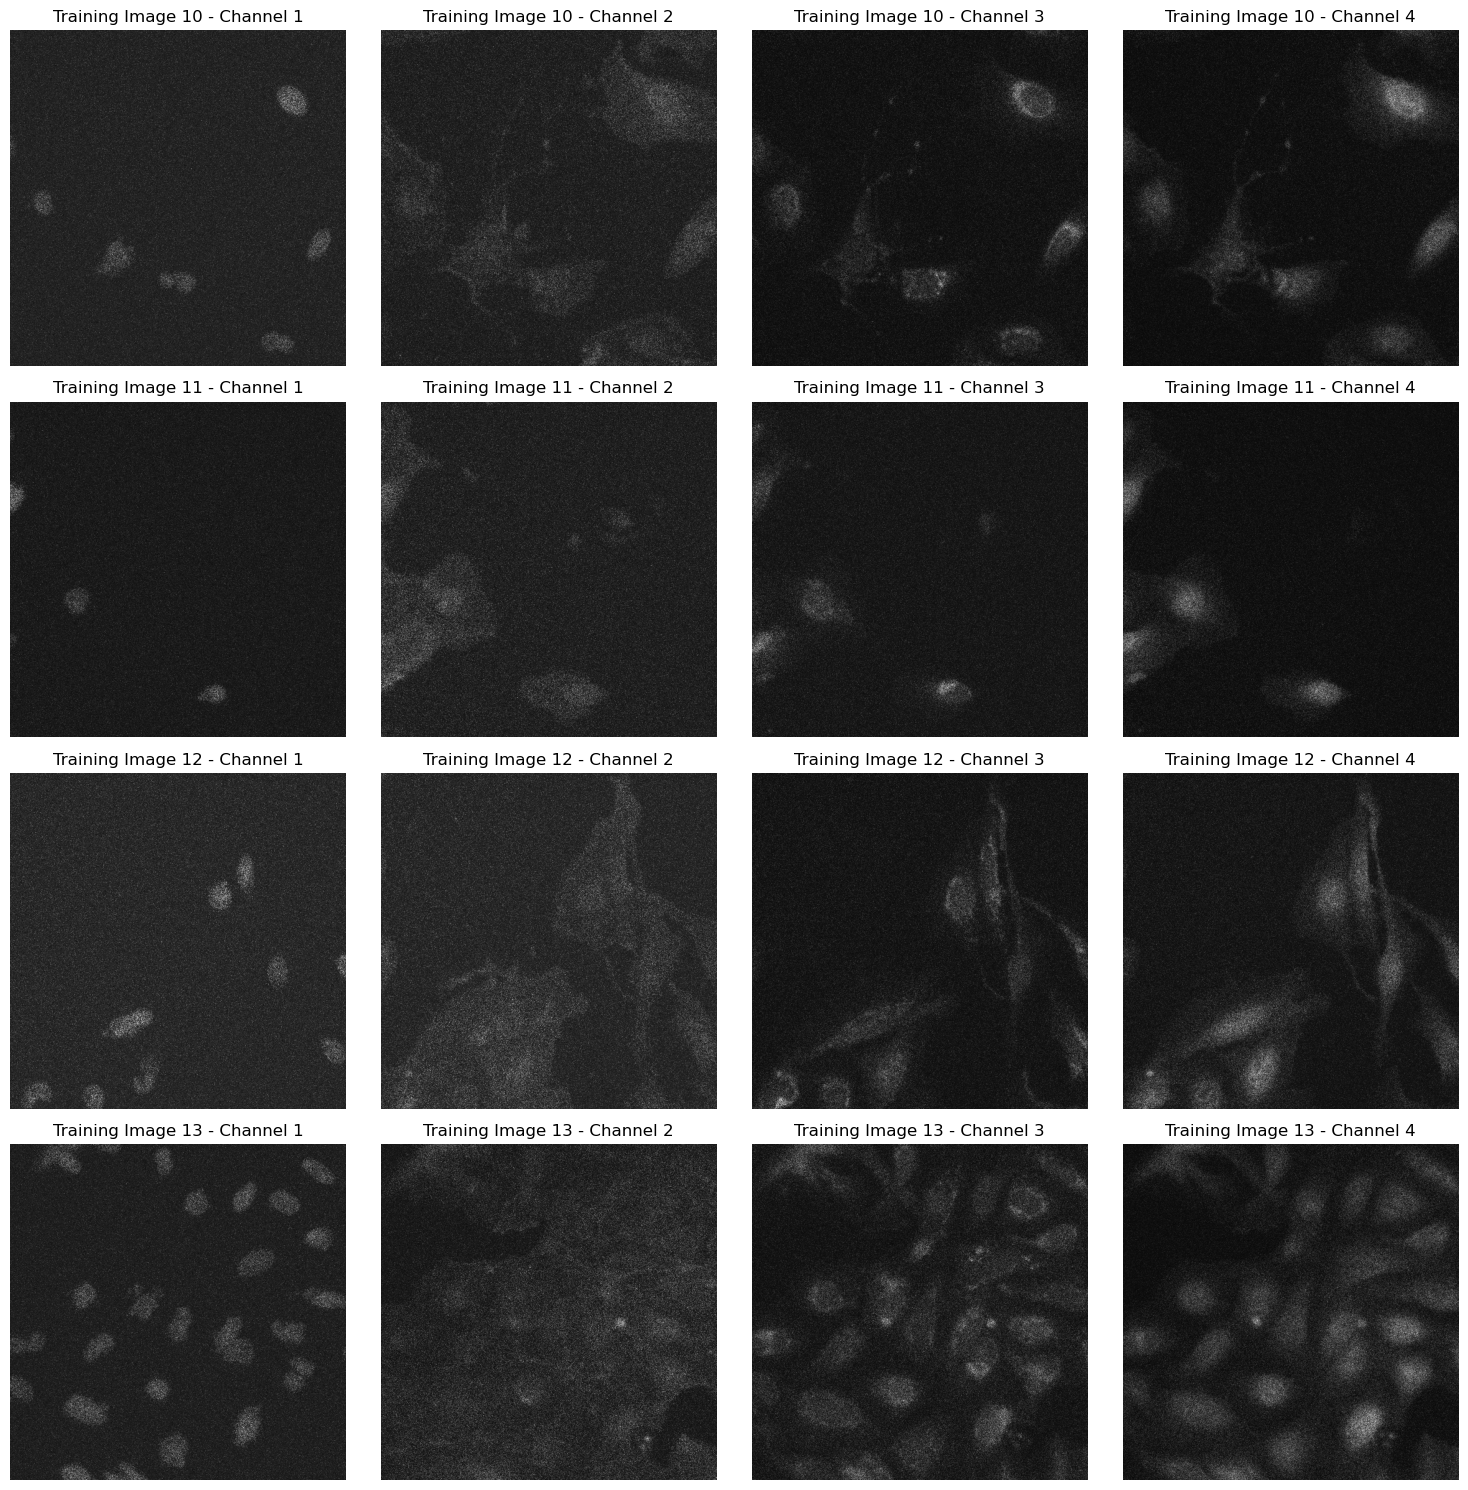

In [3]:
import tifffile
import matplotlib.pyplot as plt

# Carica le immagini di training e validation
train_images = tifffile.imread("notebooks/data/jump/noisy_train.tiff")
val_images = tifffile.imread("notebooks/data/jump/noisy_val.tiff")

# Imposta l'indice di partenza 
starting_index = 10 # immagini: 10, 11, 12, 13

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

for idx in range(starting_index, starting_index + 4):
    row = idx - starting_index  # mappa 10-13 sulle righe 0-3
    for ax, ch in zip(axes[row].flat, range(4)):
        ax.imshow(train_images[idx][ch], cmap="gray")
        ax.set_title(f"Training Image {idx} - Channel {ch+1}")
        ax.axis("off")

plt.tight_layout()
plt.show()

## Creazione della Configurazione di Addestramento

Prima di avviare l’addestramento, è necessario definire un oggetto di **configurazione** che contenga sia i parametri della rete neurale sia quelli relativi al training.

I principali parametri da impostare includono:

- `batch_size`: numero di immagini elaborate contemporaneamente in un singolo passo di addestramento.
- `num_epochs`: numero di epoche, ossia quante volte l’intero dataset di training viene utilizzato per aggiornare i pesi della rete.


In [4]:
# Creazione della configurazione per 1 epoca
config = create_n2v_configuration(
    experiment_name="jump_cells_n2v",
    data_type="array",
    axes="SCYX",
    n_channels=4,
    patch_size=(64, 64),
    batch_size=32,
    num_epochs=1,
    independent_channels=True,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 4,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 4},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'SCYX',
                 'batch_size': 32,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'transforms': [{'mean': 0.485,
    

In [5]:
# Creazione della configurazione per 10 epoche
config_10 = create_n2v_configuration(
    experiment_name="jump_cells_n2v_10",
    data_type="array",
    axes="SCYX",
    n_channels=4,
    patch_size=(64, 64),
    batch_size=32,
    num_epochs=10,
    independent_channels=True,
)

print(config_10)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 4,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 4},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'SCYX',
                 'batch_size': 32,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'transforms': [{'mean': 0.485,
    

## Addestramento del Modello

L’addestramento del modello viene effettuato creando un oggetto **CAREamist** a partire dall’oggetto di configurazione definito in precedenza.  

Il metodo `.train` richiede come input le immagini di **training** e di **validation**, che possono essere fornite tramite i percorsi di sistema in cui sono memorizzate.  

Al termine dell’addestramento, i **checkpoint migliori** vengono salvati in file dedicati con estensione `.ckpt`, per consentire di eseguire predizioni o ulteriori valutazioni senza dover ripetere l’intero training.


In [ ]:
# Addestramento modello - 1 epoca

careamist = CAREamist(source=config, work_dir="notebooks/models/jump")
print(f"Training starting now...")
careamist.train(train_source=train_images, val_source=val_images)
print("Training ended!")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/paoloparati/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Training starting now...


Computed dataset mean: 0.5690611004829407, std: 1.0805641412734985
/home/paoloparati/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/paoloparati/Downloads/PrincipiEModelliDellaPercezione/notebooks/models/jump/checkpoints exists and is not empty.

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 2.0 M  | train
---------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.147     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/paoloparati/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/home/paoloparati/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/paoloparati/anaconda3/envs/n2v/lib/python3.10/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `float` but got `float32` - serialized value may not be as expected
  Expected `float` but got `float32` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Epoch 0: 100%|██████████| 1046/1046 [1:17:14<00:00,  4.43s/it, train_loss_step=0.5, val_loss=0.575, train_loss_epoch=0.586]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1046/1046 [1:17:14<00:00,  4.43s/it, train_loss_step=0.5, val_loss=0.575, train_loss_epoch=0.586]
Training ended!


In [7]:
# Addestramento modello - 10 epoche

careamist_10 = CAREamist(source=config_10, work_dir="notebooks/models/jump_10")
print("Training 10 epoche starting...")
careamist_10.train(train_source=train_images, val_source=val_images)
print("Training 10 epoche ended!")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/paoloparati/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Training 10 epoche starting...


Computed dataset mean: 0.5690611004829407, std: 1.0805641412734985

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 2.0 M  | train
---------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.147     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/paoloparati/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/home/paoloparati/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/paoloparati/anaconda3/envs/n2v/lib/python3.10/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `float` but got `float32` - serialized value may not be as expected
  Expected `float` but got `float32` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Epoch 9: 100%|██████████| 1046/1046 [1:11:03<00:00,  4.08s/it, train_loss_step=0.397, val_loss=0.571, train_loss_epoch=0.555]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1046/1046 [1:11:03<00:00,  4.08s/it, train_loss_step=0.397, val_loss=0.571, train_loss_epoch=0.555]
Training 10 epoche ended!


## Generazione delle Predizioni

Al termine dell’addestramento, possiamo valutare il comportamento del modello chiedendogli di predire le immagini pulite a partire da campioni rumorosi.  

Nel caso dell’algoritmo **Noise2Void (N2V)**, non è necessario utilizzare un dataset separato di test, poiché l’algoritmo non apprende mai dalle Ground Truth delle immagini durante l’addestramento.  

Per generare le predizioni:

- Si utilizza l’**ultimo checkpoint salvato** del modello.
- Si predicono le prime **10 immagini** del dataset.
- Le immagini predette vengono concatenate e salvate in un unico file **.TIFF**, pronto per ulteriori analisi o visualizzazioni.

Questo procedimento consente di osservare direttamente l’efficacia del modello nel rimuovere il rumore senza compromettere i dettagli strutturali delle immagini.

In [17]:
output_path = "notebooks/predictions/jump/predictions.tiff"
predict_counter = 10 # The number of images we want to predict

predictions = []
for i in range(predict_counter):
    print(f"Predicting batch number {i}")
    pred_batch = careamist.predict(source=train_images[i], data_type='array', axes='CYX')
    predictions.append(pred_batch)

predictions = np.concatenate(predictions, axis=0).squeeze()
os.makedirs(os.path.dirname(output_path), exist_ok=True)
tifffile.imwrite(output_path, predictions)
print(f"TIFF file saved to {output_path}")


Predicting batch number 0


NameError: name 'careamist' is not defined

In [11]:
output_path_10 = "notebooks/predictions/jump/predictions_10.tiff"
predict_counter = 10  # Numero di immagini da predire

predictions_10 = []
for i in range(predict_counter):
    print(f"Predicting batch number {i} (10 epochs)")
    pred_batch = careamist.predict(source=train_images[i], data_type='array', axes='CYX')
    predictions_10.append(pred_batch)

predictions_10 = np.concatenate(predictions_10, axis=0).squeeze()

os.makedirs(os.path.dirname(output_path_10), exist_ok=True)

# salvataggio di tutte le predizioni in un unico file TIFF
tifffile.imwrite(output_path_10, predictions_10)
print(f"TIFF file saved to {output_path_10}")


Predicting batch number 0 (10 epochs)


NameError: name 'careamist' is not defined

## Visualizzazione delle Predizioni

In questa fase vengono mostrati i risultati delle predizioni del modello.  

Per semplificare l’analisi, si visualizza **solo la prima immagine** del dataset, suddivisa nei suoi **4 canali**.  

Inoltre, quando disponibili, vengono messi a confronto i risultati ottenuti con:

- `num_epochs = 1`  
- `num_epochs = 10`

Questo confronto consente di osservare come il numero di epoche influisca sulla qualità delle predizioni.  

Le immagini risultanti offrono una rappresentazione pratica delle **capacità di Noise2Void** e dei suoi limiti empirici nel preservare dettagli e texture nelle immagini denoised.


IndexError: list index out of range

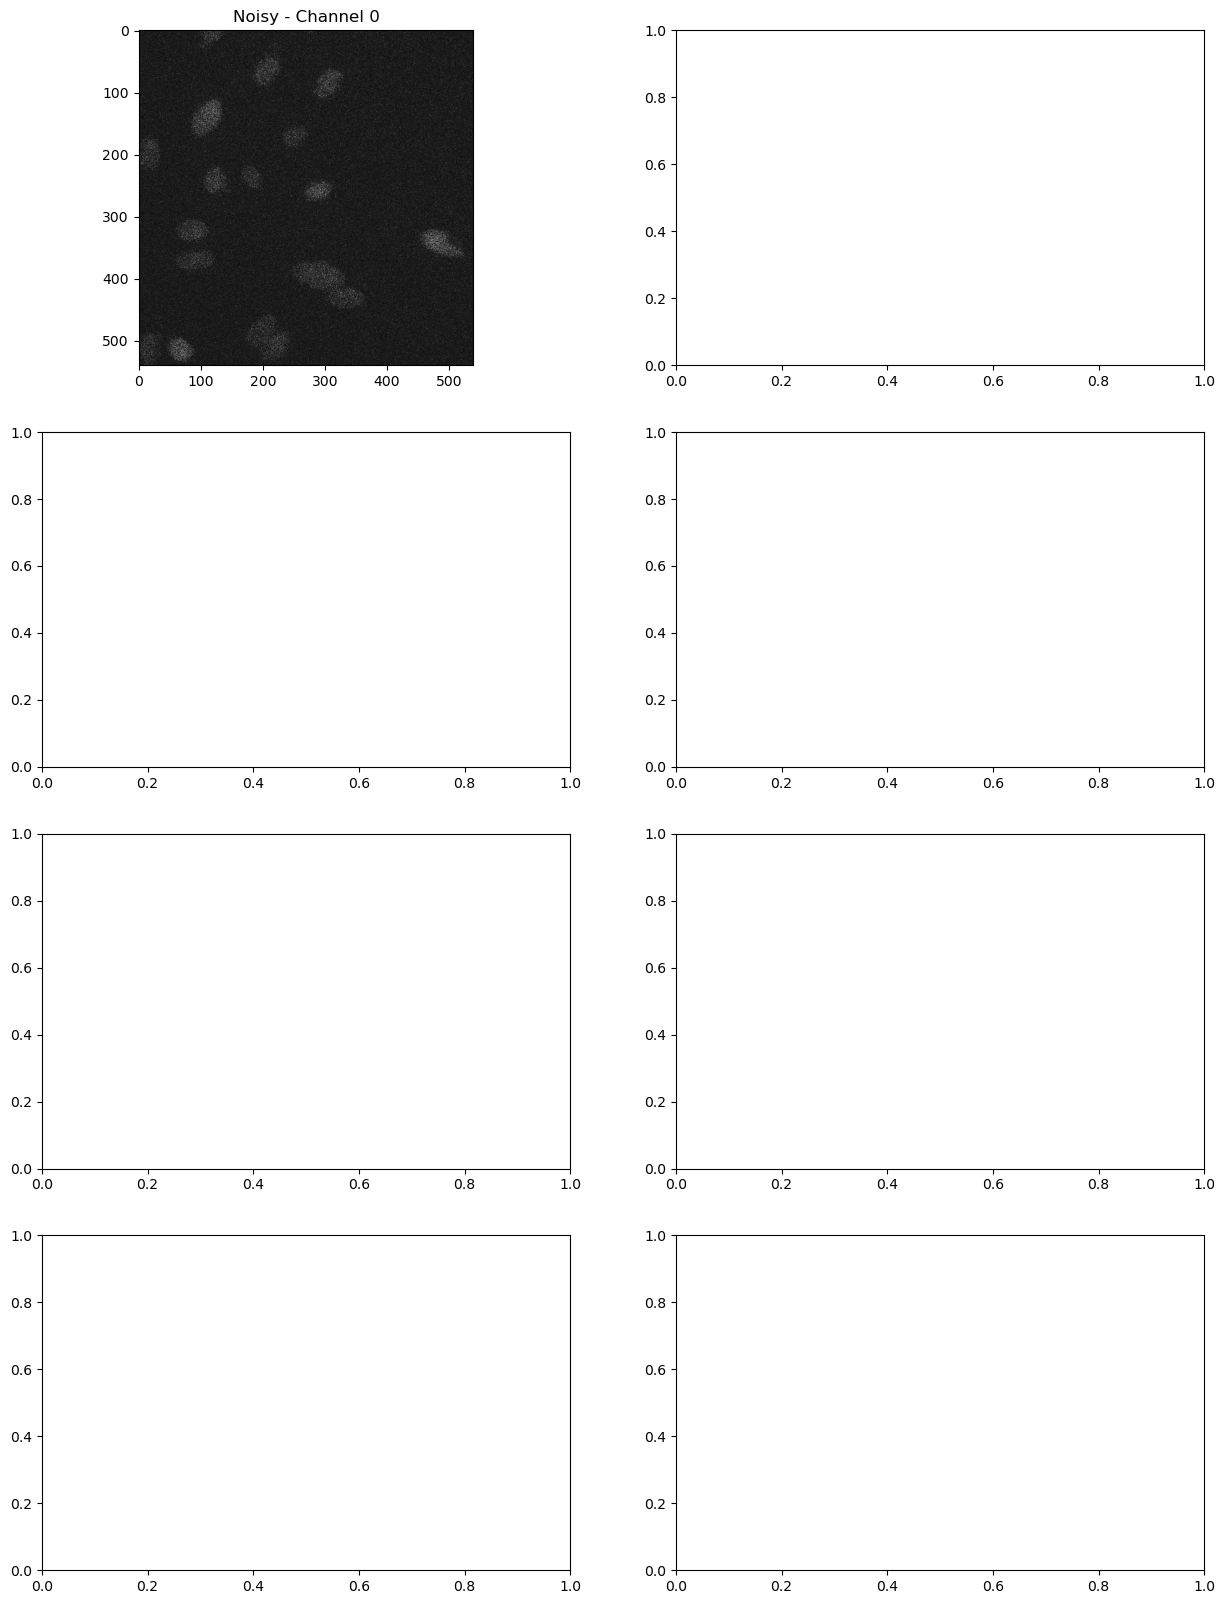

In [18]:
predictions_10_path = "notebooks/predictions/jump/predictions_10.tiff"

# Carica le predizioni se esistono
if os.path.exists(predictions_10_path):
    predictions_10 = tifffile.imread(predictions_10_path)
else:
    predictions_10 = None

# Crea la figura: 3 colonne se ci sono predizioni a 10 epoche, altrimenti 2
fig, ax = plt.subplots(4, 3 if predictions_10 is not None else 2, figsize=(15, 20))

for i in range(4):  # Mostra i 4 canali della prima immagine
    ax[i, 0].imshow(train_images[0, i], cmap="gray")
    ax[i, 0].set_title(f"Noisy - Channel {i}")
    ax[i, 1].imshow(predictions[0].squeeze()[i], cmap="gray")
    ax[i, 1].set_title("Prediction 1 Epoch")
    if predictions_10 is not None:
        ax[i, 2].imshow(predictions_10[0].squeeze()[i], cmap="gray")
        ax[i, 2].set_title("Prediction 10 Epochs")

plt.tight_layout()
plt.show()
